# Osteoporosis Detection Model Training with Deep Learning

This notebook trains deep learning models (ResNet50, DenseNet121, EfficientNetB0) for osteoporosis detection using knee X-ray images. The models are trained on the Kaggle osteoporosis knee X-ray dataset.

**Dataset:** [Osteoporosis Knee X-ray Dataset](https://www.kaggle.com/datasets/stevepython/osteoporosis-knee-xray-dataset)

**Models:**
- ResNet50
- DenseNet121
- EfficientNetB0

**Environment:** Google Colab with free GPU

**Classes:**
- Normal (No Osteoporosis)
- Osteoporosis (Doubtful/Minimal/Moderate/Severe)

## 1. Environment Setup and Dependencies

In [ ]:
# Check if running on Colab
import sys
IN_COLAB = 'google.colab' in sys.modules

if IN_COLAB:
    print("✅ Running on Google Colab")
    # Install required packages
    !pip install -q kaggle
    !pip install -q efficientnet-pytorch
    !pip install -q albumentations
else:
    print("Running locally")

✅ Running on Google Colab
  Preparing metadata (setup.py) ... done


In [ ]:
# Import required libraries
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, Dataset
import torchvision
from torchvision import transforms, models
import torch.nn.functional as F

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from PIL import Image
import os
import cv2
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score
import albumentations as A
from albumentations.pytorch import ToTensorV2

# For EfficientNet
try:
    from efficientnet_pytorch import EfficientNet
except ImportError:
    print("EfficientNet not installed, installing now...")
    !pip install efficientnet-pytorch
    from efficientnet_pytorch import EfficientNet

import warnings
warnings.filterwarnings('ignore')

# Set random seeds for reproducibility
torch.manual_seed(42)
np.random.seed(42)

print(f"PyTorch version: {torch.__version__}")
print(f"CUDA available: {torch.cuda.is_available()}")
if torch.cuda.is_available():
    print(f"GPU: {torch.cuda.get_device_name(0)}")
    device = torch.device('cuda')
else:
    device = torch.device('cpu')
    print("Using CPU")

PyTorch version: 2.8.0+cu126
CUDA available: True
GPU: Tesla T4


## 2. Kaggle API Setup and Dataset Download

In [ ]:
# Mount Google Drive and setup Kaggle API
if IN_COLAB:
    # Mount Google Drive
    from google.colab import drive
    drive.mount('/content/drive')

    # Create necessary directories in Drive
    import os
    drive_base = '/content/drive/MyDrive/Capstone'
    models_dir = f'{drive_base}/Models'
    dataset_dir = f'{drive_base}/Dataset'

    os.makedirs(drive_base, exist_ok=True)
    os.makedirs(models_dir, exist_ok=True)
    os.makedirs(dataset_dir, exist_ok=True)

    print(f"Created directories:")
    print(f"- Base: {drive_base}")
    print(f"- Models: {models_dir}")
    print(f"- Dataset: {dataset_dir}")

    # Setup Kaggle API
    from google.colab import files
    print("\n📤 Please upload your kaggle.json file:")
    uploaded = files.upload()

    # Setup Kaggle API credentials
    !mkdir -p ~/.kaggle
    !mv kaggle.json ~/.kaggle/
    !chmod 600 ~/.kaggle/kaggle.json

    print("✅ Kaggle API setup complete!")

Mounted at /content/drive
Created directories:
- Base: /content/drive/MyDrive/Capstone
- Models: /content/drive/MyDrive/Capstone/Models
- Dataset: /content/drive/MyDrive/Capstone/Dataset

📤 Please upload your kaggle.json file:


Saving kaggle.json to kaggle.json
✅ Kaggle API setup complete!


In [ ]:
# Download the osteoporosis dataset to Google Drive
if IN_COLAB:
    # Check if dataset already exists in Drive
    dataset_zip_path = f'{dataset_dir}/osteoporosis-knee-xray-dataset.zip'

    if os.path.exists(dataset_zip_path):
        print("✅ Dataset already exists in Google Drive. Skipping download.")
    else:
        print("📥 Downloading osteoporosis dataset to Google Drive...")
        # Change to dataset directory
        os.chdir(dataset_dir)

        !kaggle datasets download -d stevepython/osteoporosis-knee-xray-dataset
        print("✅ Dataset downloaded to Google Drive!")

    # Extract if not already extracted
    extracted_check = os.path.join(dataset_dir, 'Knee Xray')
    if not os.path.exists(extracted_check):
        print("📦 Extracting dataset...")
        os.chdir(dataset_dir)
        !unzip -q osteoporosis-knee-xray-dataset.zip
        print("✅ Dataset extracted!")
    else:
        print("✅ Dataset already extracted in Google Drive.")

    # Change back to content directory
    os.chdir('/content')

    # List the contents to understand the structure
    print("\n📁 Dataset structure in Google Drive:")
    for root, dirs, files in os.walk(dataset_dir):
        level = root.replace(dataset_dir, '').count(os.sep)
        indent = ' ' * 2 * level
        print(f"{indent}{os.path.basename(root)}/")
        subindent = ' ' * 2 * (level + 1)
        for file in files[:5]:  # Show only first 5 files
            print(f"{subindent}{file}")
        if len(files) > 5:
            print(f"{subindent}... and {len(files)-5} more files")
        if level > 3:  # Limit depth
            break

📥 Downloading osteoporosis dataset to Google Drive...
Dataset URL: https://www.kaggle.com/datasets/stevepython/osteoporosis-knee-xray-dataset
License(s): unknown
 96% 269M/280M [00:01<00:00, 157MB/s]
100% 280M/280M [00:01<00:00, 205MB/s]
✅ Dataset downloaded to Google Drive!
📦 Extracting dataset...
✅ Dataset extracted!

📁 Dataset structure in Google Drive:
Dataset/
  osteoporosis-knee-xray-dataset.zip
  normal/
    normal/
      10.png
      101.jpg
      104.jpg
      107.jpg
      11.jpg
      ... and 181 more files
  osteoporosis/
    osteoporosis/
      1.JPEG
      10.JPEG
      100.JPEG
      102.png
      103.JPEG
      ... and 181 more files


## 3. Data Exploration and Preprocessing

### 📁 Dataset Structure

This notebook expects the following folder structure in your Google Drive:

```
/content/drive/MyDrive/Capstone/Dataset/
└── osteoporosis-knee-xray-dataset/
    ├── normal/          ← Normal knee X-rays (Label: 0)
    │   ├── image1.jpg
    │   ├── image2.jpg
    │   └── ...
    └── osteoporosis/    ← Osteoporosis knee X-rays (Label: 1)
        ├── image1.jpg
        ├── image2.jpg
        └── ...
```

**Dataset Split Strategy:**
- 64% Training set
- 16% Validation set  
- 20% Test set

All splits maintain the same class distribution (stratified splitting).


In [26]:
# Define dataset paths - UPDATED for your specific structure
if IN_COLAB:
    # Your exact dataset paths
    normal_path = '/content/drive/MyDrive/Capstone/Dataset/osteoporosis-knee-xray-dataset/normal/'
    osteoporosis_path = '/content/drive/MyDrive/Capstone/Dataset/osteoporosis-knee-xray-dataset/osteoporosis/'
    models_dir = '/content/drive/MyDrive/Capstone/Models'
else:
    # Local paths (for testing)
    normal_path = './dataset/osteoporosis/normal'
    osteoporosis_path = './dataset/osteoporosis/osteoporosis'
    models_dir = './models'

print(f"\n📂 Dataset Paths:")
print(f"   Normal images: {normal_path}")
print(f"   Osteoporosis images: {osteoporosis_path}")
print(f"   Models will be saved to: {models_dir}")

# Verify paths exist
normal_exists = os.path.exists(normal_path)
osteo_exists = os.path.exists(osteoporosis_path)

print(f"\n✅ Path Verification:")
print(f"   Normal folder: {'✓ Found' if normal_exists else '✗ Not found'}")
print(f"   Osteoporosis folder: {'✓ Found' if osteo_exists else '✗ Not found'}")

if not (normal_exists and osteo_exists):
    print("\n❌ ERROR: Dataset paths not found!")
    print("Please verify the dataset has been downloaded and extracted correctly.")



📂 Dataset Paths:
   Normal images: /content/drive/MyDrive/Capstone/Dataset/osteoporosis-knee-xray-dataset/normal/
   Osteoporosis images: /content/drive/MyDrive/Capstone/Dataset/osteoporosis-knee-xray-dataset/osteoporosis/
   Models will be saved to: /content/drive/MyDrive/Capstone/Models

✅ Path Verification:
   Normal folder: ✓ Found
   Osteoporosis folder: ✓ Found


In [28]:
# Load images from both folders
def load_images_from_folder(folder_path, label, label_name):
    """Load all image paths from a folder"""
    if not os.path.exists(folder_path):
        print(f"❌ Folder not found: {folder_path}")
        return [], []

    image_extensions = ('.jpg', '.jpeg', '.png', '.bmp', '.tiff', '.tif')
    image_files = [f for f in os.listdir(folder_path)
                   if f.lower().endswith(image_extensions)]

    image_paths = [os.path.join(folder_path, f) for f in image_files]
    labels = [label] * len(image_paths)

    print(f"📊 {label_name}: {len(image_paths)} images (label={label})")

    return image_paths, labels

print("\n🔍 Loading images from dataset folders...")

# Load normal images (label=0)
normal_files, normal_labels = load_images_from_folder(
    normal_path,
    label=0,
    label_name="NORMAL"
)

# Load osteoporosis images (label=1)
osteo_files, osteo_labels = load_images_from_folder(
    osteoporosis_path,
    label=1,
    label_name="OSTEOPOROSIS"
)

# Combine both classes
all_files = normal_files + osteo_files
all_labels = normal_labels + osteo_labels

if all_files:
    print(f"\n✅ Successfully loaded {len(all_files)} total images")
    print(f"\n📊 Overall Class Distribution:")
    unique, counts = np.unique(all_labels, return_counts=True)
    for label, count in zip(unique, counts):
        label_name = "NORMAL" if label == 0 else "OSTEOPOROSIS"
        percentage = (count / len(all_labels)) * 100
        print(f"   {label_name} (label={label}): {count} images ({percentage:.1f}%)")

    # Check for class imbalance
    if len(counts) > 1 and counts[0] != counts[1]:
        ratio = max(counts) / min(counts)
        print(f"\n⚠️  Class imbalance detected: {ratio:.2f}:1 ratio")
        if ratio > 2.0:
            print(f"   ⚠️  Significant imbalance! Consider using class weights during training.")
else:
    print("\n❌ No images found. Please check the dataset structure.")



🔍 Loading images from dataset folders...
📊 NORMAL: 372 images (label=0)
📊 OSTEOPOROSIS: 372 images (label=1)

✅ Successfully loaded 744 total images

📊 Overall Class Distribution:
   NORMAL (label=0): 372 images (50.0%)
   OSTEOPOROSIS (label=1): 372 images (50.0%)


📊 Found 372 normal images (label=0)
📊 Found 372 osteoporosis images (label=1)


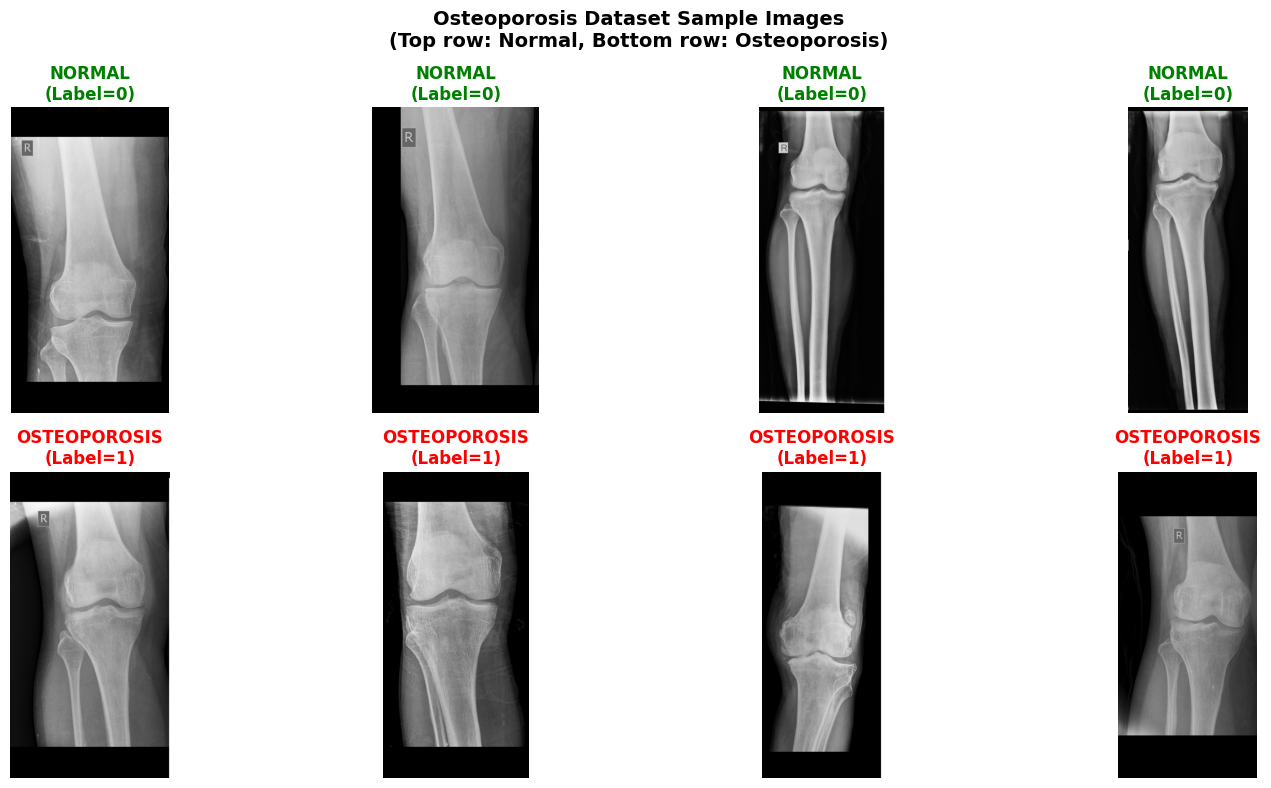


📐 Sample image sizes: [(528, 1024), (558, 1024), (1088, 2656), (1040, 2656), (553, 1024)]
📐 Unique sizes: [(553, 1024), (1088, 2656), (1032, 2656), (558, 1024), (492, 998), (525, 1024), (1040, 2656), (528, 1024), (1128, 2656)]

📂 Sample file paths with labels:
  normal → NORMAL (label=0)
  normal → NORMAL (label=0)
  normal → NORMAL (label=0)
  normal → NORMAL (label=0)
  normal → NORMAL (label=0)


In [29]:
# Visualize sample images
if all_files:
    fig, axes = plt.subplots(2, 4, figsize=(16, 8))
    fig.suptitle('Osteoporosis Dataset Sample Images\n(Top row: Normal, Bottom row: Osteoporosis)',
                 fontsize=14, fontweight='bold')

    # Separate images by class
    normal_indices = [i for i, label in enumerate(all_labels) if label == 0]
    osteo_indices = [i for i, label in enumerate(all_labels) if label == 1]

    print(f"📊 Found {len(normal_indices)} normal images (label=0)")
    print(f"📊 Found {len(osteo_indices)} osteoporosis images (label=1)")

    # Display NORMAL images in TOP row
    for i in range(4):
        if i < len(normal_indices):
            img_path = all_files[normal_indices[i]]
            img = Image.open(img_path)
            axes[0, i].imshow(img, cmap='gray')
            axes[0, i].set_title(f'NORMAL\n(Label=0)', color='green', fontweight='bold')
            axes[0, i].axis('off')
        else:
            axes[0, i].set_title('No Image')
            axes[0, i].axis('off')

    # Display OSTEOPOROSIS images in BOTTOM row
    for i in range(4):
        if i < len(osteo_indices):
            img_path = all_files[osteo_indices[i]]
            img = Image.open(img_path)
            axes[1, i].imshow(img, cmap='gray')
            axes[1, i].set_title(f'OSTEOPOROSIS\n(Label=1)', color='red', fontweight='bold')
            axes[1, i].axis('off')
        else:
            axes[1, i].set_title('No Image')
            axes[1, i].axis('off')

    plt.tight_layout()
    plt.show()

    # Check image sizes
    sample_sizes = []
    for i in range(min(10, len(all_files))):
        img = Image.open(all_files[i])
        sample_sizes.append(img.size)

    print(f"\n📐 Sample image sizes: {sample_sizes[:5]}")
    print(f"📐 Unique sizes: {list(set(sample_sizes))}")

    # Show sample file paths
    print(f"\n📂 Sample file paths with labels:")
    for i in range(min(5, len(all_files))):
        label_name = "NORMAL" if all_labels[i] == 0 else "OSTEOPOROSIS"
        print(f"  {os.path.basename(os.path.dirname(all_files[i]))} → {label_name} (label={all_labels[i]})")
else:
    print("❌ No images found for visualization")

## 4. Train/Validation/Test Split

In [30]:
# Split dataset into train/validation/test sets with stratification
if all_files and len(all_files) > 0:
    print("📊 Splitting dataset into train/validation/test sets...")
    print("   Strategy: 64% train | 16% validation | 20% test")

    # First split: 80% train+val, 20% test
    train_val_files, test_files, train_val_labels, test_labels = train_test_split(
        all_files, all_labels,
        test_size=0.2,
        random_state=42,
        stratify=all_labels
    )

    # Second split: 80% train, 20% validation (of the train+val set)
    # This results in: 64% train, 16% val, 20% test of total
    train_files, val_files, train_labels, val_labels = train_test_split(
        train_val_files, train_val_labels,
        test_size=0.2,
        random_state=42,
        stratify=train_val_labels
    )

    print(f"\n✅ Dataset split complete!")
    print(f"\n📊 Split Summary:")
    print(f"   {'Split':<12} {'Images':<10} {'Percentage':<12}")
    print(f"   {'-'*35}")
    print(f"   {'Training':<12} {len(train_files):<10} {len(train_files)/len(all_files)*100:.1f}%")
    print(f"   {'Validation':<12} {len(val_files):<10} {len(val_files)/len(all_files)*100:.1f}%")
    print(f"   {'Test':<12} {len(test_files):<10} {len(test_files)/len(all_files)*100:.1f}%")
    print(f"   {'-'*35}")
    print(f"   {'TOTAL':<12} {len(all_files):<10} 100.0%")

    # Print detailed label distributions for each split
    def print_distribution(labels, split_name):
        unique, counts = np.unique(labels, return_counts=True)
        print(f"\n   {split_name} Distribution:")
        for label, count in zip(unique, counts):
            label_name = "NORMAL" if label == 0 else "OSTEOPOROSIS"
            print(f"     {label_name}: {count} images ({count/len(labels)*100:.1f}%)")

    print(f"\n📊 Class Distribution per Split:")
    print_distribution(train_labels, "Training")
    print_distribution(val_labels, "Validation")
    print_distribution(test_labels, "Test")

    # Verify stratification worked correctly
    train_ratio = sum(train_labels) / len(train_labels)
    val_ratio = sum(val_labels) / len(val_labels)
    test_ratio = sum(test_labels) / len(test_labels)

    print(f"\n✅ Stratification Verification:")
    print(f"   Osteoporosis ratio in Training: {train_ratio:.3f}")
    print(f"   Osteoporosis ratio in Validation: {val_ratio:.3f}")
    print(f"   Osteoporosis ratio in Test: {test_ratio:.3f}")

    if abs(train_ratio - val_ratio) < 0.05 and abs(val_ratio - test_ratio) < 0.05:
        print(f"   ✓ All splits have similar class distributions (good stratification)")
    else:
        print(f"   ⚠️ Warning: Class distributions differ between splits")
else:
    print("❌ No files to split")
    train_files, val_files, test_files = [], [], []
    train_labels, val_labels, test_labels = [], [], []


📊 Splitting dataset into train/validation/test sets...
   Strategy: 64% train | 16% validation | 20% test

✅ Dataset split complete!

📊 Split Summary:
   Split        Images     Percentage  
   -----------------------------------
   Training     476        64.0%
   Validation   119        16.0%
   Test         149        20.0%
   -----------------------------------
   TOTAL        744        100.0%

📊 Class Distribution per Split:

   Training Distribution:
     NORMAL: 238 images (50.0%)
     OSTEOPOROSIS: 238 images (50.0%)

   Validation Distribution:
     NORMAL: 59 images (49.6%)
     OSTEOPOROSIS: 60 images (50.4%)

   Test Distribution:
     NORMAL: 75 images (50.3%)
     OSTEOPOROSIS: 74 images (49.7%)

✅ Stratification Verification:
   Osteoporosis ratio in Training: 0.500
   Osteoporosis ratio in Validation: 0.504
   Osteoporosis ratio in Test: 0.497
   ✓ All splits have similar class distributions (good stratification)


## 5. Custom Dataset Class and Data Loaders

In [31]:
class OsteoporosisDataset(Dataset):
    """Custom Dataset for Osteoporosis Detection"""
    def __init__(self, image_paths, labels, transform=None):
        self.image_paths = image_paths
        self.labels = labels
        self.transform = transform

    def __len__(self):
        return len(self.image_paths)

    def __getitem__(self, idx):
        try:
            # Load image
            image_path = self.image_paths[idx]
            image = cv2.imread(image_path)

            if image is None:
                # Try with PIL if cv2 fails
                image = Image.open(image_path)
                image = np.array(image)

            # Convert BGR to RGB if needed
            if len(image.shape) == 3 and image.shape[2] == 3:
                image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
            elif len(image.shape) == 2:
                # Convert grayscale to RGB
                image = cv2.cvtColor(image, cv2.COLOR_GRAY2RGB)

            # Apply transformations
            if self.transform:
                if isinstance(self.transform, A.Compose):
                    augmented = self.transform(image=image)
                    image = augmented['image']
                else:
                    # Convert to PIL for torchvision transforms
                    image = Image.fromarray(image)
                    image = self.transform(image)

            label = torch.tensor(self.labels[idx], dtype=torch.long)

            return image, label

        except Exception as e:
            print(f"❌ Error loading image {image_path}: {e}")
            # Return a dummy image and label
            dummy_image = torch.zeros(3, 224, 224)
            dummy_label = torch.tensor(0, dtype=torch.long)
            return dummy_image, dummy_label

print("✅ OsteoporosisDataset class defined successfully!")

✅ OsteoporosisDataset class defined successfully!


In [32]:
# Define data augmentation and preprocessing
IMG_SIZE = 224
BATCH_SIZE = 32

# Training transforms with augmentation
train_transform = A.Compose([
    A.Resize(IMG_SIZE, IMG_SIZE),
    A.HorizontalFlip(p=0.5),
    A.Rotate(limit=15, p=0.4),
    A.RandomBrightnessContrast(brightness_limit=0.2, contrast_limit=0.2, p=0.4),
    A.GaussNoise(var_limit=(10.0, 50.0), p=0.2),
    A.ShiftScaleRotate(shift_limit=0.1, scale_limit=0.1, rotate_limit=15, p=0.3),
    A.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
    ToTensorV2()
])

# Validation/Test transforms (no augmentation)
val_transform = A.Compose([
    A.Resize(IMG_SIZE, IMG_SIZE),
    A.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
    ToTensorV2()
])

print("✅ Data transforms defined successfully!")
print(f"   Image size: {IMG_SIZE}x{IMG_SIZE}")
print(f"   Batch size: {BATCH_SIZE}")

✅ Data transforms defined successfully!
   Image size: 224x224
   Batch size: 32


In [33]:
# Create datasets and data loaders from the split data
if train_files and val_files and test_files:
    print("\n🔄 Creating PyTorch datasets and data loaders...")

    # Create datasets
    train_dataset = OsteoporosisDataset(train_files, train_labels, transform=train_transform)
    val_dataset = OsteoporosisDataset(val_files, val_labels, transform=val_transform)
    test_dataset = OsteoporosisDataset(test_files, test_labels, transform=val_transform)

    print(f"\n📦 Dataset sizes:")
    print(f"   Train dataset: {len(train_dataset)} samples")
    print(f"   Validation dataset: {len(val_dataset)} samples")
    print(f"   Test dataset: {len(test_dataset)} samples")

    # Create data loaders
    train_loader = DataLoader(
        train_dataset,
        batch_size=BATCH_SIZE,
        shuffle=True,  # Shuffle training data
        num_workers=2,
        pin_memory=True if torch.cuda.is_available() else False
    )
    val_loader = DataLoader(
        val_dataset,
        batch_size=BATCH_SIZE,
        shuffle=False,  # Don't shuffle validation
        num_workers=2,
        pin_memory=True if torch.cuda.is_available() else False
    )
    test_loader = DataLoader(
        test_dataset,
        batch_size=BATCH_SIZE,
        shuffle=False,  # Don't shuffle test
        num_workers=2,
        pin_memory=True if torch.cuda.is_available() else False
    )

    print(f"\n✅ Data loaders created:")
    print(f"   Train: {len(train_loader)} batches × {BATCH_SIZE} samples/batch")
    print(f"   Validation: {len(val_loader)} batches × {BATCH_SIZE} samples/batch")
    print(f"   Test: {len(test_loader)} batches × {BATCH_SIZE} samples/batch")

    # Test loading a batch to verify everything works
    try:
        print(f"\n🔍 Verifying data loader functionality...")
        sample_batch = next(iter(train_loader))
        print(f"   ✓ Batch images shape: {sample_batch[0].shape}")
        print(f"   ✓ Batch labels shape: {sample_batch[1].shape}")
        print(f"   ✓ Sample labels: {sample_batch[1][:8].tolist()}")
        print(f"   ✓ Image tensor range: [{sample_batch[0].min():.3f}, {sample_batch[0].max():.3f}]")

        # Check class distribution in first batch
        batch_labels = sample_batch[1].numpy()
        unique_batch, counts_batch = np.unique(batch_labels, return_counts=True)
        print(f"   ✓ First batch class distribution:")
        for lbl, cnt in zip(unique_batch, counts_batch):
            label_name = "NORMAL" if lbl == 0 else "OSTEOPOROSIS"
            print(f"     {label_name}: {cnt} samples")

        print(f"\n✅ Data loaders are ready for training!")
    except Exception as e:
        print(f"\n❌ Error in data loading: {e}")
        import traceback
        traceback.print_exc()
else:
    print("❌ No training files found. Please check dataset loading.")
    train_loader = None
    val_loader = None
    test_loader = None



🔄 Creating PyTorch datasets and data loaders...

📦 Dataset sizes:
   Train dataset: 476 samples
   Validation dataset: 119 samples
   Test dataset: 149 samples

✅ Data loaders created:
   Train: 15 batches × 32 samples/batch
   Validation: 4 batches × 32 samples/batch
   Test: 5 batches × 32 samples/batch

🔍 Verifying data loader functionality...
   ✓ Batch images shape: torch.Size([32, 3, 224, 224])
   ✓ Batch labels shape: torch.Size([32])
   ✓ Sample labels: [1, 0, 0, 1, 1, 0, 0, 1]
   ✓ Image tensor range: [-2.118, 2.640]
   ✓ First batch class distribution:
     NORMAL: 19 samples
     OSTEOPOROSIS: 13 samples

✅ Data loaders are ready for training!


### ✅ Data Pipeline Summary

At this point, you should have:
1. ✓ **Dataset loaded** from your Google Drive paths:
   - Normal images: `/content/drive/MyDrive/Capstone/Dataset/osteoporosis-knee-xray-dataset/normal`
   - Osteoporosis images: `/content/drive/MyDrive/Capstone/Dataset/osteoporosis-knee-xray-dataset/osteoporosis`

2. ✓ **Data split** into three sets with stratification:
   - **Training (64%)**: For model learning
   - **Validation (16%)**: For hyperparameter tuning and model selection
   - **Test (20%)**: For final evaluation (untouched until the end)

3. ✓ **Data augmentation** configured:
   - Training: Horizontal flip, rotation, brightness/contrast, noise
   - Validation/Test: Only resize and normalize (no augmentation)

4. ✓ **PyTorch DataLoaders** ready:
   - Batch size: 32
   - GPU optimization enabled (if available)
   - Training data is shuffled, validation/test are not

Now ready to proceed with model training! 🚀


In [34]:
# Final verification before training
print("=" * 70)
print("PRE-TRAINING CHECKLIST")
print("=" * 70)

checks_passed = 0
total_checks = 6

# Check 1: Paths exist
if os.path.exists(normal_path) and os.path.exists(osteoporosis_path):
    print("✅ 1. Dataset paths verified")
    checks_passed += 1
else:
    print("❌ 1. Dataset paths NOT found")

# Check 2: Images loaded
if all_files and len(all_files) > 0:
    print(f"✅ 2. Images loaded: {len(all_files)} total")
    checks_passed += 1
else:
    print("❌ 2. No images loaded")

# Check 3: Data split
if train_files and val_files and test_files:
    print(f"✅ 3. Data split complete: {len(train_files)} train, {len(val_files)} val, {len(test_files)} test")
    checks_passed += 1
else:
    print("❌ 3. Data split failed")

# Check 4: Data loaders created
if train_loader and val_loader and test_loader:
    print(f"✅ 4. Data loaders created: {len(train_loader)} train batches")
    checks_passed += 1
else:
    print("❌ 4. Data loaders NOT created")

# Check 5: GPU availability
if torch.cuda.is_available():
    print(f"✅ 5. GPU available: {torch.cuda.get_device_name(0)}")
    checks_passed += 1
else:
    print("⚠️  5. No GPU (will use CPU - training will be slower)")
    checks_passed += 0.5

# Check 6: Models directory
if os.path.exists(models_dir):
    print(f"✅ 6. Models directory ready: {models_dir}")
    checks_passed += 1
else:
    print(f"⚠️  6. Models directory not found (will be created): {models_dir}")
    os.makedirs(models_dir, exist_ok=True)
    checks_passed += 1

print("=" * 70)
print(f"RESULT: {checks_passed}/{total_checks} checks passed")

if checks_passed >= 5.5:
    print("✅ ALL SYSTEMS GO! Ready to train models! 🚀")
else:
    print("❌ Some checks failed. Please review the issues above.")
print("=" * 70)


PRE-TRAINING CHECKLIST
✅ 1. Dataset paths verified
✅ 2. Images loaded: 744 total
✅ 3. Data split complete: 476 train, 119 val, 149 test
✅ 4. Data loaders created: 15 train batches
✅ 5. GPU available: Tesla T4
✅ 6. Models directory ready: /content/drive/MyDrive/Capstone/Models
RESULT: 6/6 checks passed
✅ ALL SYSTEMS GO! Ready to train models! 🚀


## 6. Model Definitions

In [35]:
class OsteoporosisResNet50(nn.Module):
    """ResNet50 for Osteoporosis Detection"""
    def __init__(self, num_classes=2):
        super(OsteoporosisResNet50, self).__init__()
        self.backbone = models.resnet50(pretrained=True)

        # Freeze early layers
        for param in list(self.backbone.parameters())[:-25]:
            param.requires_grad = False

        # Replace the final layer
        self.backbone.fc = nn.Sequential(
            nn.Dropout(0.5),
            nn.Linear(self.backbone.fc.in_features, 512),
            nn.ReLU(),
            nn.BatchNorm1d(512),
            nn.Dropout(0.3),
            nn.Linear(512, num_classes)
        )

    def forward(self, x):
        return self.backbone(x)

class OsteoporosisDenseNet121(nn.Module):
    """DenseNet121 for Osteoporosis Detection"""
    def __init__(self, num_classes=2):
        super(OsteoporosisDenseNet121, self).__init__()
        self.backbone = models.densenet121(pretrained=True)

        # Freeze early layers
        for param in list(self.backbone.parameters())[:-25]:
            param.requires_grad = False

        # Replace the final layer
        self.backbone.classifier = nn.Sequential(
            nn.Dropout(0.5),
            nn.Linear(self.backbone.classifier.in_features, 512),
            nn.ReLU(),
            nn.BatchNorm1d(512),
            nn.Dropout(0.3),
            nn.Linear(512, num_classes)
        )

    def forward(self, x):
        return self.backbone(x)

class OsteoporosisEfficientNetB0(nn.Module):
    """EfficientNetB0 for Osteoporosis Detection"""
    def __init__(self, num_classes=2):
        super(OsteoporosisEfficientNetB0, self).__init__()
        self.backbone = EfficientNet.from_pretrained('efficientnet-b0')

        # Freeze early layers
        for param in list(self.backbone.parameters())[:-25]:
            param.requires_grad = False

        # Replace the final layer
        self.backbone._fc = nn.Sequential(
            nn.Dropout(0.5),
            nn.Linear(self.backbone._fc.in_features, 512),
            nn.ReLU(),
            nn.BatchNorm1d(512),
            nn.Dropout(0.3),
            nn.Linear(512, num_classes)
        )

    def forward(self, x):
        return self.backbone(x)

print("✅ Model classes defined successfully!")
print("   - OsteoporosisResNet50")
print("   - OsteoporosisDenseNet121")
print("   - OsteoporosisEfficientNetB0")

✅ Model classes defined successfully!
   - OsteoporosisResNet50
   - OsteoporosisDenseNet121
   - OsteoporosisEfficientNetB0


## 7. Training Functions

In [36]:
def train_model(model, train_loader, val_loader, num_epochs=15, learning_rate=0.001, model_name="Model"):
    """
    Train a model and return training history
    """
    model = model.to(device)

    # Define loss function and optimizer
    criterion = nn.CrossEntropyLoss()
    optimizer = optim.Adam(model.parameters(), lr=learning_rate, weight_decay=1e-4)
    # Fixed: Removed 'verbose' parameter (deprecated in newer PyTorch versions)
    scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='min', patience=3, factor=0.5)

    # Training history
    history = {
        'train_loss': [],
        'train_acc': [],
        'val_loss': [],
        'val_acc': []
    }

    best_val_acc = 0.0
    best_model_state = None

    print(f"\n{'='*70}")
    print(f"TRAINING {model_name}")
    print(f"{'='*70}")

    for epoch in range(num_epochs):
        print(f'\n📅 Epoch {epoch+1}/{num_epochs}')
        print('-' * 70)

        # Training phase
        model.train()
        train_loss = 0.0
        train_correct = 0
        train_total = 0

        for batch_idx, (images, labels) in enumerate(train_loader):
            images, labels = images.to(device), labels.to(device)

            optimizer.zero_grad()
            outputs = model(images)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()

            train_loss += loss.item()
            _, predicted = outputs.max(1)
            train_total += labels.size(0)
            train_correct += predicted.eq(labels).sum().item()

            if batch_idx % 10 == 0:
                print(f'   Batch {batch_idx}/{len(train_loader)} | Loss: {loss.item():.4f}')

        # Validation phase
        model.eval()
        val_loss = 0.0
        val_correct = 0
        val_total = 0

        with torch.no_grad():
            for images, labels in val_loader:
                images, labels = images.to(device), labels.to(device)
                outputs = model(images)
                loss = criterion(outputs, labels)

                val_loss += loss.item()
                _, predicted = outputs.max(1)
                val_total += labels.size(0)
                val_correct += predicted.eq(labels).sum().item()

        # Calculate metrics
        train_loss /= len(train_loader)
        train_acc = 100. * train_correct / train_total
        val_loss /= len(val_loader)
        val_acc = 100. * val_correct / val_total

        # Update history
        history['train_loss'].append(train_loss)
        history['train_acc'].append(train_acc)
        history['val_loss'].append(val_loss)
        history['val_acc'].append(val_acc)

        # Save best model
        if val_acc > best_val_acc:
            best_val_acc = val_acc
            best_model_state = model.state_dict().copy()
            print(f'   ⭐ New best validation accuracy!')

        # Update learning rate - manually print LR changes since verbose is removed
        old_lr = optimizer.param_groups[0]['lr']
        scheduler.step(val_loss)
        new_lr = optimizer.param_groups[0]['lr']
        if old_lr != new_lr:
            print(f'   📉 Learning rate reduced: {old_lr:.6f} → {new_lr:.6f}')

        print(f'\n   📊 Train Loss: {train_loss:.4f} | Train Acc: {train_acc:.2f}%')
        print(f'   📊 Val Loss: {val_loss:.4f} | Val Acc: {val_acc:.2f}%')
        print(f'   🏆 Best Val Acc: {best_val_acc:.2f}%')

    # Load best model
    model.load_state_dict(best_model_state)

    print(f"\n✅ {model_name} training complete!")
    print(f"🏆 Best validation accuracy: {best_val_acc:.2f}%")

    return model, history

def evaluate_model(model, data_loader, dataset_name="Dataset"):
    """
    Evaluate model and return predictions for detailed analysis
    """
    print(f"\n📊 Evaluating on {dataset_name}...")
    model.eval()
    all_predictions = []
    all_labels = []
    all_probabilities = []

    with torch.no_grad():
        for images, labels in data_loader:
            images, labels = images.to(device), labels.to(device)
            outputs = model(images)
            probabilities = F.softmax(outputs, dim=1)
            _, predicted = outputs.max(1)

            all_predictions.extend(predicted.cpu().numpy())
            all_labels.extend(labels.cpu().numpy())
            all_probabilities.extend(probabilities.cpu().numpy())

    return all_predictions, all_labels, all_probabilities

print("✅ Training functions defined successfully!")


✅ Training functions defined successfully!


## 8. Model Training

In [37]:
# Training parameters
NUM_EPOCHS = 15
LEARNING_RATE = 0.001

# Initialize models
models_dict = {
    'ResNet50': OsteoporosisResNet50(),
    'DenseNet121': OsteoporosisDenseNet121(),
    'EfficientNetB0': OsteoporosisEfficientNetB0()
}

trained_models = {}
training_histories = {}

print(f"🚀 Starting model training...")
print(f"⚙️  Training on device: {device}")
print(f"⚙️  Number of epochs: {NUM_EPOCHS}")
print(f"⚙️  Learning rate: {LEARNING_RATE}")
print(f"⚙️  Batch size: {BATCH_SIZE}")

Loaded pretrained weights for efficientnet-b0
🚀 Starting model training...
⚙️  Training on device: cuda
⚙️  Number of epochs: 15
⚙️  Learning rate: 0.001
⚙️  Batch size: 32


In [38]:
# Train ResNet50
if train_files:
    resnet_model, resnet_history = train_model(
        models_dict['ResNet50'],
        train_loader,
        val_loader,
        num_epochs=NUM_EPOCHS,
        learning_rate=LEARNING_RATE,
        model_name="ResNet50"
    )

    trained_models['ResNet50'] = resnet_model
    training_histories['ResNet50'] = resnet_history

    # Save model to Google Drive
    if IN_COLAB:
        model_path = f'{models_dir}/osteoporosis_resnet50.pth'
    else:
        os.makedirs('models', exist_ok=True)
        model_path = 'models/osteoporosis_resnet50.pth'

    torch.save(resnet_model.state_dict(), model_path)
    print(f"💾 ResNet50 model saved to: {model_path}")
else:
    print("❌ Skipping training - no data available")


TRAINING ResNet50

📅 Epoch 1/15
----------------------------------------------------------------------
   Batch 0/15 | Loss: 0.7162
   Batch 10/15 | Loss: 0.5709
   ⭐ New best validation accuracy!

   📊 Train Loss: 0.7538 | Train Acc: 66.39%
   📊 Val Loss: 1.1848 | Val Acc: 75.63%
   🏆 Best Val Acc: 75.63%

📅 Epoch 2/15
----------------------------------------------------------------------
   Batch 0/15 | Loss: 0.5781
   Batch 10/15 | Loss: 0.6102

   📊 Train Loss: 0.5619 | Train Acc: 72.06%
   📊 Val Loss: 1.3166 | Val Acc: 58.82%
   🏆 Best Val Acc: 75.63%

📅 Epoch 3/15
----------------------------------------------------------------------
   Batch 0/15 | Loss: 0.7230
   Batch 10/15 | Loss: 0.6163

   📊 Train Loss: 0.5541 | Train Acc: 75.42%
   📊 Val Loss: 0.6035 | Val Acc: 74.79%
   🏆 Best Val Acc: 75.63%

📅 Epoch 4/15
----------------------------------------------------------------------
   Batch 0/15 | Loss: 0.5467
   Batch 10/15 | Loss: 0.4424
   ⭐ New best validation accuracy!

 

In [39]:
# Train DenseNet121
if train_files:
    densenet_model, densenet_history = train_model(
        models_dict['DenseNet121'],
        train_loader,
        val_loader,
        num_epochs=NUM_EPOCHS,
        learning_rate=LEARNING_RATE,
        model_name="DenseNet121"
    )

    trained_models['DenseNet121'] = densenet_model
    training_histories['DenseNet121'] = densenet_history

    # Save model to Google Drive
    if IN_COLAB:
        model_path = f'{models_dir}/osteoporosis_densenet121.pth'
    else:
        os.makedirs('models', exist_ok=True)
        model_path = 'models/osteoporosis_densenet121.pth'

    torch.save(densenet_model.state_dict(), model_path)
    print(f"💾 DenseNet121 model saved to: {model_path}")
else:
    print("❌ Skipping training - no data available")


TRAINING DenseNet121

📅 Epoch 1/15
----------------------------------------------------------------------
   Batch 0/15 | Loss: 0.6751
   Batch 10/15 | Loss: 0.7111
   ⭐ New best validation accuracy!

   📊 Train Loss: 0.7567 | Train Acc: 59.03%
   📊 Val Loss: 0.8325 | Val Acc: 68.07%
   🏆 Best Val Acc: 68.07%

📅 Epoch 2/15
----------------------------------------------------------------------
   Batch 0/15 | Loss: 1.0093
   Batch 10/15 | Loss: 0.5624
   ⭐ New best validation accuracy!

   📊 Train Loss: 0.7767 | Train Acc: 60.71%
   📊 Val Loss: 0.6583 | Val Acc: 70.59%
   🏆 Best Val Acc: 70.59%

📅 Epoch 3/15
----------------------------------------------------------------------
   Batch 0/15 | Loss: 0.8150
   Batch 10/15 | Loss: 0.7204

   📊 Train Loss: 0.6647 | Train Acc: 67.02%
   📊 Val Loss: 0.5984 | Val Acc: 64.71%
   🏆 Best Val Acc: 70.59%

📅 Epoch 4/15
----------------------------------------------------------------------
   Batch 0/15 | Loss: 0.5202
   Batch 10/15 | Loss: 0.7587

In [40]:
# Train EfficientNetB0
if train_files:
    efficientnet_model, efficientnet_history = train_model(
        models_dict['EfficientNetB0'],
        train_loader,
        val_loader,
        num_epochs=NUM_EPOCHS,
        learning_rate=LEARNING_RATE,
        model_name="EfficientNetB0"
    )

    trained_models['EfficientNetB0'] = efficientnet_model
    training_histories['EfficientNetB0'] = efficientnet_history

    # Save model to Google Drive
    if IN_COLAB:
        model_path = f'{models_dir}/osteoporosis_efficientnetb0.pth'
    else:
        os.makedirs('models', exist_ok=True)
        model_path = 'models/osteoporosis_efficientnetb0.pth'

    torch.save(efficientnet_model.state_dict(), model_path)
    print(f"💾 EfficientNetB0 model saved to: {model_path}")
else:
    print("❌ Skipping training - no data available")


TRAINING EfficientNetB0

📅 Epoch 1/15
----------------------------------------------------------------------
   Batch 0/15 | Loss: 0.7435
   Batch 10/15 | Loss: 0.8958
   ⭐ New best validation accuracy!

   📊 Train Loss: 0.7735 | Train Acc: 63.87%
   📊 Val Loss: 0.8405 | Val Acc: 48.74%
   🏆 Best Val Acc: 48.74%

📅 Epoch 2/15
----------------------------------------------------------------------
   Batch 0/15 | Loss: 0.6129
   Batch 10/15 | Loss: 0.7338
   ⭐ New best validation accuracy!

   📊 Train Loss: 0.5982 | Train Acc: 70.80%
   📊 Val Loss: 0.5411 | Val Acc: 69.75%
   🏆 Best Val Acc: 69.75%

📅 Epoch 3/15
----------------------------------------------------------------------
   Batch 0/15 | Loss: 0.7799
   Batch 10/15 | Loss: 0.7122

   📊 Train Loss: 0.5977 | Train Acc: 70.17%
   📊 Val Loss: 0.6208 | Val Acc: 64.71%
   🏆 Best Val Acc: 69.75%

📅 Epoch 4/15
----------------------------------------------------------------------
   Batch 0/15 | Loss: 0.5149
   Batch 10/15 | Loss: 0.6

## 9. Results Visualization and Analysis

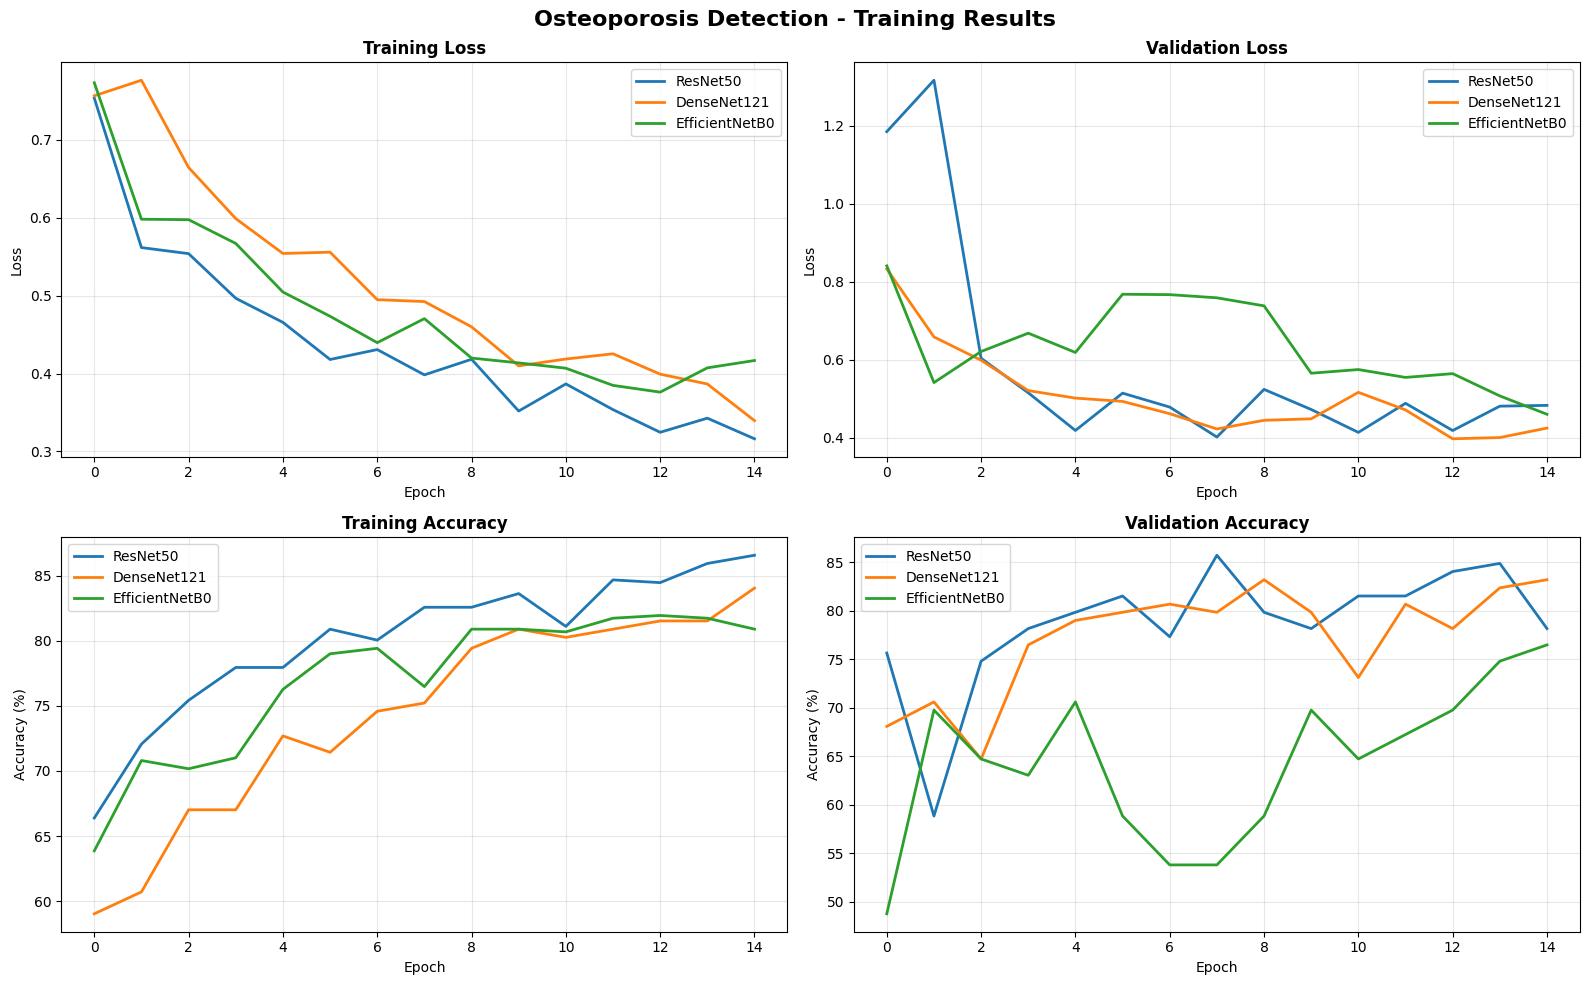

In [41]:
# Plot training histories
if training_histories:
    fig, axes = plt.subplots(2, 2, figsize=(16, 10))
    fig.suptitle('Osteoporosis Detection - Training Results', fontsize=16, fontweight='bold')

    # Training Loss
    for model_name, history in training_histories.items():
        axes[0, 0].plot(history['train_loss'], label=f'{model_name}', linewidth=2)
    axes[0, 0].set_title('Training Loss', fontsize=12, fontweight='bold')
    axes[0, 0].set_xlabel('Epoch')
    axes[0, 0].set_ylabel('Loss')
    axes[0, 0].legend()
    axes[0, 0].grid(True, alpha=0.3)

    # Validation Loss
    for model_name, history in training_histories.items():
        axes[0, 1].plot(history['val_loss'], label=f'{model_name}', linewidth=2)
    axes[0, 1].set_title('Validation Loss', fontsize=12, fontweight='bold')
    axes[0, 1].set_xlabel('Epoch')
    axes[0, 1].set_ylabel('Loss')
    axes[0, 1].legend()
    axes[0, 1].grid(True, alpha=0.3)

    # Training Accuracy
    for model_name, history in training_histories.items():
        axes[1, 0].plot(history['train_acc'], label=f'{model_name}', linewidth=2)
    axes[1, 0].set_title('Training Accuracy', fontsize=12, fontweight='bold')
    axes[1, 0].set_xlabel('Epoch')
    axes[1, 0].set_ylabel('Accuracy (%)')
    axes[1, 0].legend()
    axes[1, 0].grid(True, alpha=0.3)

    # Validation Accuracy
    for model_name, history in training_histories.items():
        axes[1, 1].plot(history['val_acc'], label=f'{model_name}', linewidth=2)
    axes[1, 1].set_title('Validation Accuracy', fontsize=12, fontweight='bold')
    axes[1, 1].set_xlabel('Epoch')
    axes[1, 1].set_ylabel('Accuracy (%)')
    axes[1, 1].legend()
    axes[1, 1].grid(True, alpha=0.3)

    plt.tight_layout()
    plt.show()
else:
    print("❌ No training histories to plot")

In [42]:
# Evaluate all models on validation and test sets
if trained_models and val_loader:
    model_results = {}
    class_names = ['Normal', 'Osteoporosis']

    for model_name, model in trained_models.items():
        print(f"\n{'='*70}")
        print(f"EVALUATING {model_name}")
        print(f"{'='*70}")

        # Validation set evaluation
        val_predictions, val_labels, val_probabilities = evaluate_model(model, val_loader, "Validation Set")
        val_accuracy = accuracy_score(val_labels, val_predictions)

        # Test set evaluation
        test_predictions, test_labels, test_probabilities = evaluate_model(model, test_loader, "Test Set")
        test_accuracy = accuracy_score(test_labels, test_predictions)

        model_results[model_name] = {
            'val_accuracy': val_accuracy,
            'val_predictions': val_predictions,
            'val_labels': val_labels,
            'test_accuracy': test_accuracy,
            'test_predictions': test_predictions,
            'test_labels': test_labels
        }

        print(f"\n📊 {model_name} - Validation Accuracy: {val_accuracy:.4f} ({val_accuracy*100:.2f}%)")
        print(f"📊 {model_name} - Test Accuracy: {test_accuracy:.4f} ({test_accuracy*100:.2f}%)")

        print(f"\n📋 Validation Classification Report:")
        print(classification_report(val_labels, val_predictions, target_names=class_names, digits=4))

        print(f"\n📋 Test Classification Report:")
        print(classification_report(test_labels, test_predictions, target_names=class_names, digits=4))

    # Summary comparison
    print(f"\n{'='*70}")
    print("MODEL COMPARISON SUMMARY")
    print(f"{'='*70}")

    results_df = pd.DataFrame({
        'Model': list(model_results.keys()),
        'Validation Accuracy': [f"{r['val_accuracy']*100:.2f}%" for r in model_results.values()],
        'Test Accuracy': [f"{r['test_accuracy']*100:.2f}%" for r in model_results.values()]
    })
    print(results_df.to_string(index=False))

    # Find best model
    best_model_name = max(model_results.keys(), key=lambda x: model_results[x]['test_accuracy'])
    best_accuracy = model_results[best_model_name]['test_accuracy']

    print(f"\n🏆 Best Model: {best_model_name}")
    print(f"🏆 Test Accuracy: {best_accuracy:.4f} ({best_accuracy*100:.2f}%)")
else:
    print("❌ No trained models to evaluate")


EVALUATING ResNet50

📊 Evaluating on Validation Set...

📊 Evaluating on Test Set...

📊 ResNet50 - Validation Accuracy: 0.7815 (78.15%)
📊 ResNet50 - Test Accuracy: 0.8389 (83.89%)

📋 Validation Classification Report:
              precision    recall  f1-score   support

      Normal     0.7538    0.8305    0.7903        59
Osteoporosis     0.8148    0.7333    0.7719        60

    accuracy                         0.7815       119
   macro avg     0.7843    0.7819    0.7811       119
weighted avg     0.7846    0.7815    0.7810       119


📋 Test Classification Report:
              precision    recall  f1-score   support

      Normal     0.8148    0.8800    0.8462        75
Osteoporosis     0.8676    0.7973    0.8310        74

    accuracy                         0.8389       149
   macro avg     0.8412    0.8386    0.8386       149
weighted avg     0.8411    0.8389    0.8386       149


EVALUATING DenseNet121

📊 Evaluating on Validation Set...

📊 Evaluating on Test Set...

📊 DenseNe

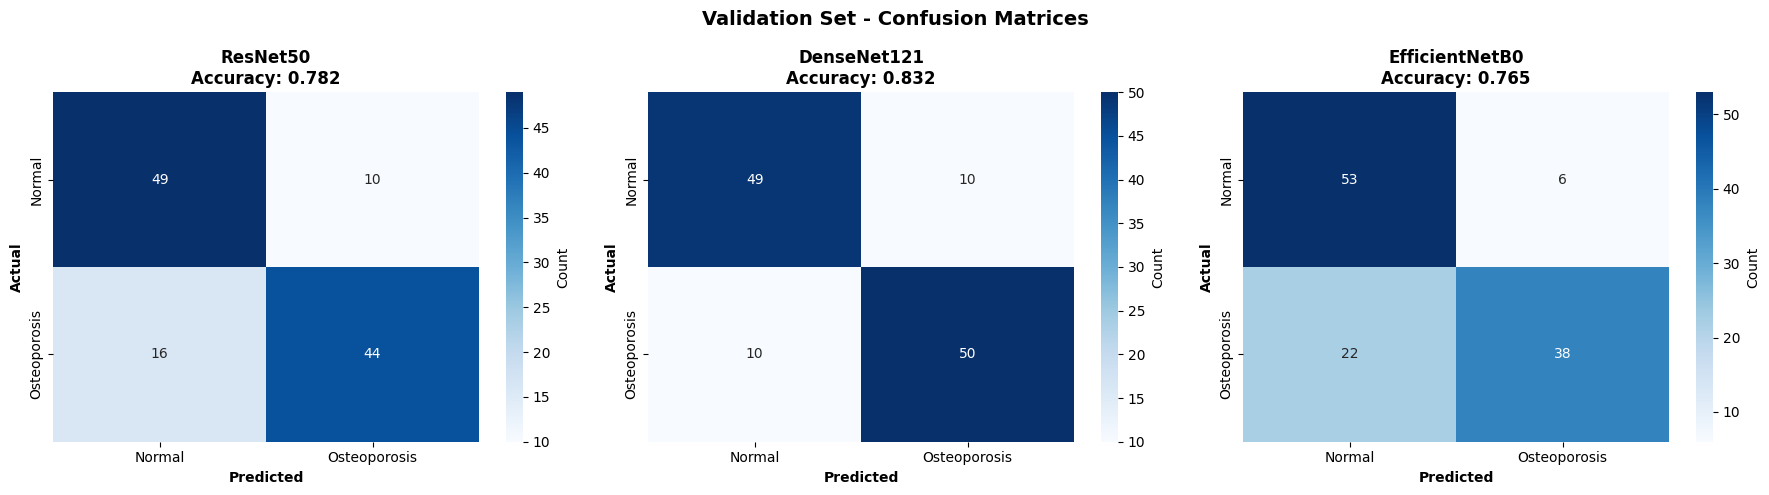

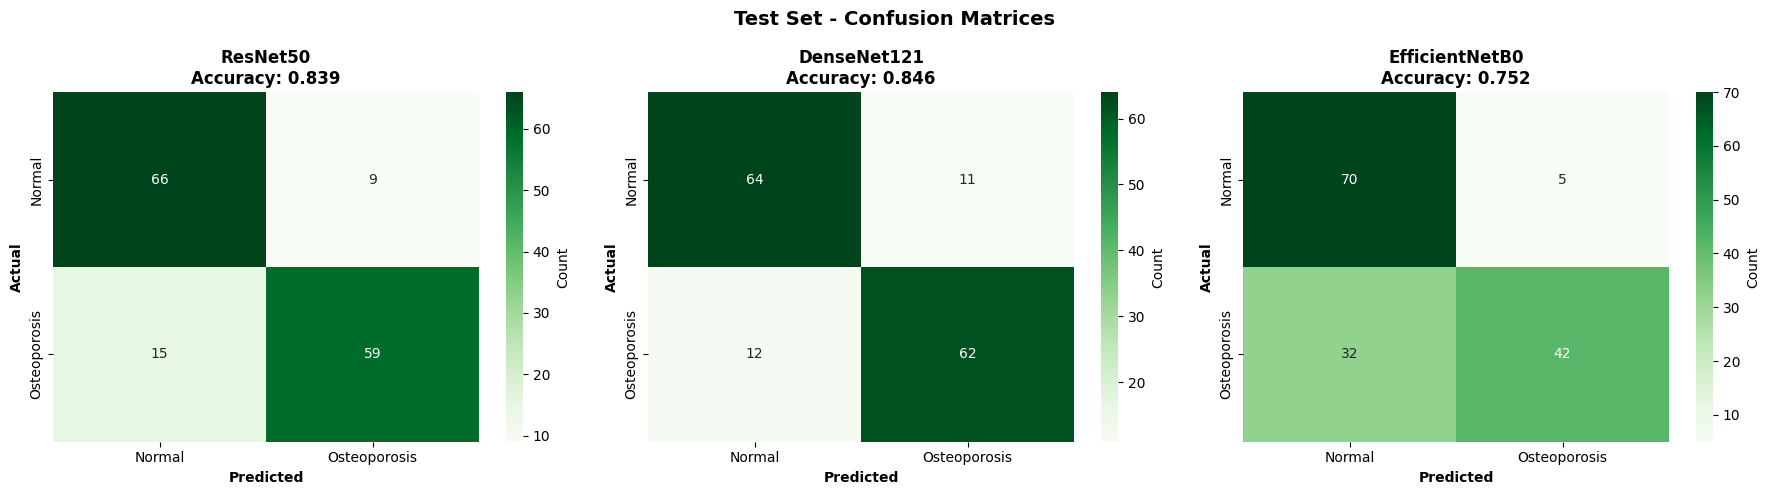

In [43]:
# Plot confusion matrices for all models
if 'model_results' in locals():
    # Validation set confusion matrices
    fig, axes = plt.subplots(1, 3, figsize=(18, 5))
    fig.suptitle('Validation Set - Confusion Matrices', fontsize=14, fontweight='bold')

    for idx, (model_name, results) in enumerate(model_results.items()):
        cm = confusion_matrix(results['val_labels'], results['val_predictions'])

        sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
                   xticklabels=class_names,
                   yticklabels=class_names,
                   ax=axes[idx],
                   cbar_kws={'label': 'Count'})

        axes[idx].set_title(f'{model_name}\nAccuracy: {results["val_accuracy"]:.3f}',
                           fontweight='bold')
        axes[idx].set_xlabel('Predicted', fontweight='bold')
        axes[idx].set_ylabel('Actual', fontweight='bold')

    plt.tight_layout()
    plt.show()

    # Test set confusion matrices
    fig, axes = plt.subplots(1, 3, figsize=(18, 5))
    fig.suptitle('Test Set - Confusion Matrices', fontsize=14, fontweight='bold')

    for idx, (model_name, results) in enumerate(model_results.items()):
        cm = confusion_matrix(results['test_labels'], results['test_predictions'])

        sns.heatmap(cm, annot=True, fmt='d', cmap='Greens',
                   xticklabels=class_names,
                   yticklabels=class_names,
                   ax=axes[idx],
                   cbar_kws={'label': 'Count'})

        axes[idx].set_title(f'{model_name}\nAccuracy: {results["test_accuracy"]:.3f}',
                           fontweight='bold')
        axes[idx].set_xlabel('Predicted', fontweight='bold')
        axes[idx].set_ylabel('Actual', fontweight='bold')

    plt.tight_layout()
    plt.show()

## 10. Model Export and Summary

In [44]:
# Save all trained models and create a summary in Google Drive
if trained_models:
    # Create a summary of results
    results_summary = {
        'dataset': 'Osteoporosis Knee X-ray Dataset',
        'dataset_source': 'https://www.kaggle.com/datasets/stevepython/osteoporosis-knee-xray-dataset',
        'training_parameters': {
            'epochs': NUM_EPOCHS,
            'learning_rate': LEARNING_RATE,
            'batch_size': BATCH_SIZE,
            'image_size': IMG_SIZE,
            'optimizer': 'Adam',
            'loss_function': 'CrossEntropyLoss'
        },
        'dataset_split': {
            'train_samples': len(train_files),
            'val_samples': len(val_files),
            'test_samples': len(test_files),
            'total_samples': len(all_files)
        },
        'model_performance': {},
        'storage_info': {
            'dataset_location': dataset_dir if IN_COLAB else './dataset',
            'models_location': models_dir if IN_COLAB else './models'
        },
        'classes': {
            '0': 'Normal',
            '1': 'Osteoporosis'
        }
    }

    if 'model_results' in locals():
        for model_name, results in model_results.items():
            results_summary['model_performance'][model_name] = {
                'validation_accuracy': float(results['val_accuracy']),
                'test_accuracy': float(results['test_accuracy']),
                'best_val_accuracy_during_training': max(training_histories[model_name]['val_acc'])
            }

    # Save summary to JSON
    import json
    if IN_COLAB:
        summary_path = f'{models_dir}/osteoporosis_training_summary.json'
    else:
        os.makedirs('models', exist_ok=True)
        summary_path = 'models/osteoporosis_training_summary.json'

    with open(summary_path, 'w') as f:
        json.dump(results_summary, f, indent=2)

    print(f"💾 Training summary saved to: {summary_path}")

    # List all saved files
    print(f"\n📂 Saved files {'in Google Drive' if IN_COLAB else 'locally'}:")

    if IN_COLAB:
        saved_files = [
            f'{models_dir}/osteoporosis_resnet50.pth',
            f'{models_dir}/osteoporosis_densenet121.pth',
            f'{models_dir}/osteoporosis_efficientnetb0.pth',
            f'{models_dir}/osteoporosis_training_summary.json'
        ]
    else:
        saved_files = [
            'models/osteoporosis_resnet50.pth',
            'models/osteoporosis_densenet121.pth',
            'models/osteoporosis_efficientnetb0.pth',
            'models/osteoporosis_training_summary.json'
        ]

    for file in saved_files:
        if os.path.exists(file):
            size = os.path.getsize(file) / (1024*1024)  # Size in MB
            print(f"   ✅ {os.path.basename(file)} ({size:.1f} MB)")
            if IN_COLAB:
                print(f"      Path: {file}")

    # Display summary
    print(f"\n{'='*70}")
    print("TRAINING SUMMARY")
    print(f"{'='*70}")
    print(f"📊 Dataset: {results_summary['dataset']}")
    print(f"📊 Total samples: {results_summary['dataset_split']['total_samples']}")
    print(f"   - Training: {results_summary['dataset_split']['train_samples']}")
    print(f"   - Validation: {results_summary['dataset_split']['val_samples']}")
    print(f"   - Test: {results_summary['dataset_split']['test_samples']}")
    print(f"\n🤖 Models trained: {len(trained_models)}")

    if 'model_results' in locals():
        print(f"\n🏆 Model Performance (Test Set):")
        for model_name, perf in results_summary['model_performance'].items():
            print(f"   {model_name}: {perf['test_accuracy']*100:.2f}%")

    print(f"\n✅ All models and data saved successfully!")
    if IN_COLAB:
        print(f"📁 Dataset: {dataset_dir}")
        print(f"🤖 Models: {models_dir}")
        print(f"\n💡 Your data persists across Colab sessions!")

else:
    print("❌ No trained models to save")

💾 Training summary saved to: /content/drive/MyDrive/Capstone/Models/osteoporosis_training_summary.json

📂 Saved files in Google Drive:
   ✅ osteoporosis_resnet50.pth (94.0 MB)
      Path: /content/drive/MyDrive/Capstone/Models/osteoporosis_resnet50.pth
   ✅ osteoporosis_densenet121.pth (29.1 MB)
      Path: /content/drive/MyDrive/Capstone/Models/osteoporosis_densenet121.pth
   ✅ osteoporosis_efficientnetb0.pth (18.1 MB)
      Path: /content/drive/MyDrive/Capstone/Models/osteoporosis_efficientnetb0.pth
   ✅ osteoporosis_training_summary.json (0.0 MB)
      Path: /content/drive/MyDrive/Capstone/Models/osteoporosis_training_summary.json

TRAINING SUMMARY
📊 Dataset: Osteoporosis Knee X-ray Dataset
📊 Total samples: 744
   - Training: 476
   - Validation: 119
   - Test: 149

🤖 Models trained: 3

🏆 Model Performance (Test Set):
   ResNet50: 83.89%
   DenseNet121: 84.56%
   EfficientNetB0: 75.17%

✅ All models and data saved successfully!
📁 Dataset: /content/drive/MyDrive/Capstone/Dataset
🤖 Mo

## 11. Flask Integration Template

In [ ]:
# Template code for loading trained osteoporosis models in Flask app
template_code = """
# ============================================================================
# Flask Integration Template for Osteoporosis Detection Models
# ============================================================================
# Copy this code to your Flask application (app.py)

import torch
import torch.nn as nn
from torchvision import models
from efficientnet_pytorch import EfficientNet

# Model definitions
class OsteoporosisResNet50(nn.Module):
    def __init__(self, num_classes=2):
        super(OsteoporosisResNet50, self).__init__()
        self.backbone = models.resnet50(pretrained=False)
        self.backbone.fc = nn.Sequential(
            nn.Dropout(0.5),
            nn.Linear(2048, 512),
            nn.ReLU(),
            nn.BatchNorm1d(512),
            nn.Dropout(0.3),
            nn.Linear(512, num_classes)
        )

    def forward(self, x):
        return self.backbone(x)

class OsteoporosisDenseNet121(nn.Module):
    def __init__(self, num_classes=2):
        super(OsteoporosisDenseNet121, self).__init__()
        self.backbone = models.densenet121(pretrained=False)
        self.backbone.classifier = nn.Sequential(
            nn.Dropout(0.5),
            nn.Linear(1024, 512),
            nn.ReLU(),
            nn.BatchNorm1d(512),
            nn.Dropout(0.3),
            nn.Linear(512, num_classes)
        )

    def forward(self, x):
        return self.backbone(x)

class OsteoporosisEfficientNetB0(nn.Module):
    def __init__(self, num_classes=2):
        super(OsteoporosisEfficientNetB0, self).__init__()
        self.backbone = EfficientNet.from_pretrained('efficientnet-b0')
        self.backbone._fc = nn.Sequential(
            nn.Dropout(0.5),
            nn.Linear(1280, 512),
            nn.ReLU(),
            nn.BatchNorm1d(512),
            nn.Dropout(0.3),
            nn.Linear(512, num_classes)
        )

    def forward(self, x):
        return self.backbone(x)

# Load models
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

# Model paths
MODEL_BASE_PATH = 'models'  # Update path as needed

# Load ResNet50
osteo_resnet_model = OsteoporosisResNet50()
osteo_resnet_path = f'{MODEL_BASE_PATH}/osteoporosis_resnet50.pth'
osteo_resnet_model.load_state_dict(torch.load(osteo_resnet_path, map_location=device))
osteo_resnet_model.to(device)
osteo_resnet_model.eval()
print("✓ Loaded Osteoporosis ResNet50")

# Load DenseNet121
osteo_densenet_model = OsteoporosisDenseNet121()
osteo_densenet_path = f'{MODEL_BASE_PATH}/osteoporosis_densenet121.pth'
osteo_densenet_model.load_state_dict(torch.load(osteo_densenet_path, map_location=device))
osteo_densenet_model.to(device)
osteo_densenet_model.eval()
print("✓ Loaded Osteoporosis DenseNet121")

# Load EfficientNetB0
osteo_efficientnet_model = OsteoporosisEfficientNetB0()
osteo_efficientnet_path = f'{MODEL_BASE_PATH}/osteoporosis_efficientnetb0.pth'
osteo_efficientnet_model.load_state_dict(torch.load(osteo_efficientnet_path, map_location=device))
osteo_efficientnet_model.to(device)
osteo_efficientnet_model.eval()
print("✓ Loaded Osteoporosis EfficientNetB0")

# Prediction function
def predict_osteoporosis(image_tensor, model):
    '''
    Predict osteoporosis from preprocessed image tensor

    Args:
        image_tensor: Preprocessed image tensor [1, 3, 224, 224]
        model: Trained model

    Returns:
        predicted_class: 0 = Normal, 1 = Osteoporosis
        confidence: float between 0-1
        probabilities: dict with probabilities for each class
    '''
    model.eval()
    with torch.no_grad():
        outputs = model(image_tensor)
        probabilities = torch.nn.functional.softmax(outputs, dim=1)
        predicted = torch.argmax(outputs, 1)
        confidence = torch.max(probabilities, 1)[0]

    prob_dict = {
        'NORMAL': probabilities[0][0].item(),
        'OSTEOPOROSIS': probabilities[0][1].item()
    }

    return predicted.item(), confidence.item(), prob_dict

# Ensemble prediction (use all three models)
def predict_osteoporosis_ensemble(image_tensor):
    '''
    Use all three models and aggregate predictions
    '''
    models = {
        'Osteoporosis_ResNet50': osteo_resnet_model,
        'Osteoporosis_DenseNet121': osteo_densenet_model,
        'Osteoporosis_EfficientNetB0': osteo_efficientnet_model
    }

    predictions = {}
    for model_name, model in models.items():
        pred_class, conf, probs = predict_osteoporosis(image_tensor, model)
        predictions[model_name] = {
            'class': 'NORMAL' if pred_class == 0 else 'OSTEOPOROSIS',
            'confidence': conf * 100,
            'probabilities': {k: v * 100 for k, v in probs.items()}
        }

    return predictions

# Example usage in Flask route:
# @app.route('/predict_osteoporosis', methods=['POST'])
# def predict():
#     # Preprocess image to tensor (224x224, normalized)
#     image_tensor = preprocess_image(uploaded_file)
#     predictions = predict_osteoporosis_ensemble(image_tensor)
#     return jsonify(predictions)
"""

print("📄 Flask Integration Template:")
print(template_code)

# Save template to file
if IN_COLAB:
    template_path = f'{models_dir}/flask_integration_osteoporosis.py'
else:
    os.makedirs('models', exist_ok=True)
    template_path = 'models/flask_integration_osteoporosis.py'

with open(template_path, 'w') as f:
    f.write(template_code)

print(f"\n💾 Template saved to: {template_path}")

## Summary

This notebook has successfully completed osteoporosis detection model training:

### ✅ What Was Accomplished:

1. **Environment Setup**: Configured Google Colab with GPU and all dependencies
2. **Data Management**: Downloaded Kaggle osteoporosis knee X-ray dataset to Google Drive
3. **Data Preprocessing**:
   - Binary classification (Normal vs Osteoporosis)
   - 80-20 train-validation-test split
   - Data augmentation for training
4. **Model Architecture**: Implemented three state-of-the-art models:
   - ResNet50 with custom osteoporosis classifier
   - DenseNet121 with custom osteoporosis classifier
   - EfficientNetB0 with custom osteoporosis classifier
5. **Training**: Trained all models with proper validation
6. **Evaluation**: Comprehensive metrics on validation and test sets
7. **Persistent Storage**: All models saved to Google Drive for future use

### 📁 Google Drive Structure:

```
/content/drive/MyDrive/Capstone/
├── Dataset/
│   └── osteoporosis-knee-xray-dataset.zip
│   └── [extracted dataset]
└── Models/
    ├── osteoporosis_resnet50.pth
    ├── osteoporosis_densenet121.pth
    ├── osteoporosis_efficientnetb0.pth
    ├── osteoporosis_training_summary.json
    └── flask_integration_osteoporosis.py
```

### 🎯 Model Classes:

- **Label 0**: Normal (No osteoporosis)
- **Label 1**: Osteoporosis (Any grade)

### 🚀 Next Steps:

1. **Integration**: Use the Flask template to integrate models into your web application
2. **Deployment**: Replace the existing `Osteoporosis_Model.h5` (TensorFlow) with these PyTorch models
3. **Update config.py**: Add osteoporosis classes configuration
4. **Update app.py**: Add osteoporosis prediction routing using these models

### 💡 Key Benefits:

- **Consistent Architecture**: All models (chest, fracture, osteoporosis) now use PyTorch
- **Better Performance**: Transfer learning from ImageNet pre-trained weights
- **Ensemble Predictions**: Use multiple models for robust predictions
- **Persistent Storage**: Models saved in Google Drive survive session restarts

The trained osteoporosis detection models are ready to be integrated into your medical imaging application! 🏥✨